In [1]:
import matplotlib.pyplot as plt
from skimage.segmentation import slic
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from numpy import zeros, newaxis
import math

### Load ResNet50 pre-trained model

In [2]:
# Download the ResNet50 pre-trained model.
resnet50_model = models.resnet50(pretrained = True) # pretrained: If True, returns a model pre-trained on ImageNet.
print(resnet50_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
layers_dict = {
    "layer 1": -5,
    "layer 2": -4,
    "layer 3": -3,
    "layer 4": -2
}

# Create a new model that its output is the output of the chosen intermediate layer from resnet50 model.
resnet50_intermediate_layer_model = nn.Sequential(*list(resnet50_model.children())[:layers_dict["layer 2"]])

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

### Load Best MLP model

In [5]:
# Create a feedforward NN with:
# 1 hidden layer with self.first_hidden_size neurons and Relu activation function.
# 1 output layer with 3 neurons and softmax activation function.
class MLP(torch.nn.Module):
        def __init__(self, input_size, first_hidden_size):
            super(MLP, self).__init__()
            self.input_size = input_size
            self.first_hidden_size  = first_hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.first_hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.first_hidden_size, 3)
            self.softmax = torch.nn.Softmax(dim = 1)
            
            
        def forward(self, x):
            first_hidden = self.fc1(x)
            first_relu = self.relu(first_hidden)
            
            output = self.fc2(first_relu)
            output = self.softmax(output)
            return output

In [6]:
input_layer_size = 512 #256 or 512 or 1024 or 2048
first_hidden_layer_size = round(math.sqrt(input_layer_size * 3))

# Load best model.
best_model_directory = r"C:\Nikolaos Sintoris\Education\MEng CSE - UOI\Diploma Thesis\Scanning\Train results\ResNet50 Classifier\Layer 2\Best model\state_dict_model.pt"

my_model = MLP(input_layer_size, first_hidden_layer_size)

my_model.load_state_dict(torch.load(best_model_directory))

<All keys matched successfully>

### Apply SuperPixel slic algorithm to an image

In [7]:
# Load image from hard drive.
image_directory = r"C:\Nikolaos Sintoris\Education\MEng CSE - UOI\Diploma Thesis\Scanning\Scanning dataset\im1.jpg"
mask_directory = r"C:\Nikolaos Sintoris\Education\MEng CSE - UOI\Diploma Thesis\Scanning\Scanning dataset\mask1.jpg"

image = np.array(Image.open(image_directory))
mask = np.array(Image.open(mask_directory))
print("Image shape: ", image.shape)
print("Mask shape: ", mask.shape)

final_image = np.copy(image) # Create a shallow copy.

# Apply superpixel slic algorithm and get all the labels.
segments = slic(image, n_segments = 5000)

#print("Segments: \n", segments)

# Create a list that has all the different labels values.
labels_list = np.unique(segments)
print("Total number of labels: ", labels_list[-1])

Image shape:  (7826, 4630, 3)
Mask shape:  (7826, 4630)
	Total number of labels:  4931


In [8]:
# Where mask has value different from 0, change it to 255.
mask = np.where(mask != 0, 255, mask)

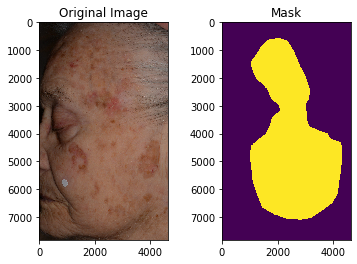

In [9]:
f = plt.figure()

f.add_subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")

f.add_subplot(1, 2, 2)
plt.imshow(mask)
plt.title("Mask")

plt.show(block = True)

In [10]:
def averagePooling(my_tensor):
    temp_tensor = nn.AvgPool2d(my_tensor.shape[-1])(my_tensor)
    final_tensor = temp_tensor[:, :, -1]# Convert from 3D to 2D tensor.
    return final_tensor.T # Transpose the tensor in order to have a vector.

def find_centroid(an_array, value):
    coordinates = np.where(an_array == value)
    x_coordinates = coordinates[0]
    y_coordinates = coordinates[1]
    centroid = (int(round(sum(x_coordinates) / len(x_coordinates))), int(round(sum(y_coordinates) / len(y_coordinates))))
    return centroid

# Create a window with shape 50x50 that it's center is the centroid.
def create_sub_image(an_image, centroid):
    start_row = 0
    end_row = an_image.shape[0]
    start_column = 0
    end_column = an_image.shape[1]
    if((centroid[0] - 25) > 0):
        start_row = centroid[0] - 25
    if((centroid[0] + 24) < an_image.shape[0]):
        end_row = centroid[0] + 24
    if((centroid[1] - 25) > 0):
        start_column = centroid[1] - 25
    if((centroid[1] + 24) < an_image.shape[1]):
        end_column = centroid[1] + 24
        
    sub_image_np = an_image[start_row:end_row + 1, start_column:end_column + 1]
    transformed_sub_image = transform(sub_image_np)
    sub_image = torch.unsqueeze(transformed_sub_image, 0)
    
    return sub_image

In [11]:
# For every label
#  1) Find the centroid
#  2) Find a window with shape 50x50 based on the centroid
#  3) Pass as input this sub_image to my model and check if it is AK or not
#  4) If it is AK, then color all the pixels with that label with red.

red_color = np.array([255, 0, 0])
segments2 = segments[:, :, newaxis]
for current_label in labels_list:
    current_centroid = find_centroid(segments, current_label)
    if(mask[current_centroid[0]][current_centroid[1]] == 255):

        current_sub_image = create_sub_image(image, current_centroid)

        resnet50_intermediate_layer_model.eval()
        with torch.no_grad():
            classifier_a = resnet50_intermediate_layer_model(current_sub_image)
            classifier_b = classifier_a[-1, :, :, :] # Convert from 4D to 3D tensor.
            classifier_output = averagePooling(classifier_b)

        my_model.eval()
        predicted_labels = my_model(classifier_output)

        predicted_probability, predicted_class = torch.max(predicted_labels.data, 1)
        
        if(predicted_class.item() == 0):
            final_image = np.where(segments2 == current_label, red_color, final_image)

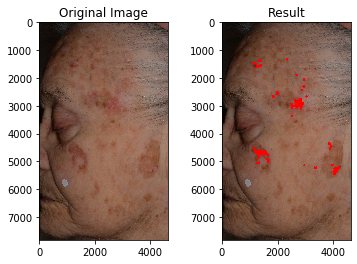

In [12]:
f = plt.figure()

f.add_subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")

f.add_subplot(1, 2, 2)
plt.imshow(final_image)
plt.title("Result")

plt.show(block = True)